# Blind Quantum Computing

Este notebook executa o código de Blind Quantum Computing utilizando Qiskit. O objetivo é demonstrar como rodar experimentos quânticos de forma segura e privada, utilizando um dataset de exemplo (Iris).

In [1]:
import random
import matplotlib.pyplot as plt
from quantumnet.components import Network, Logger

In [2]:
# Instalar dependências
!pip install qiskit
!pip install matplotlib
!pip install qiskit qiskit-machine-learning scikit-learn torch

In [3]:
import random
from quantumnet.components import Network, Host
from quantumnet.components import ServerNode, ClientNode, RegularNode
from quantumnet.objects import Qubit, Logger

In [4]:
# instalar as bibliotecas necessárias

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import numpy as np


# Inicializar a rede

Hosts inicializados
Canais inicializados
Pares EPRs adicionados


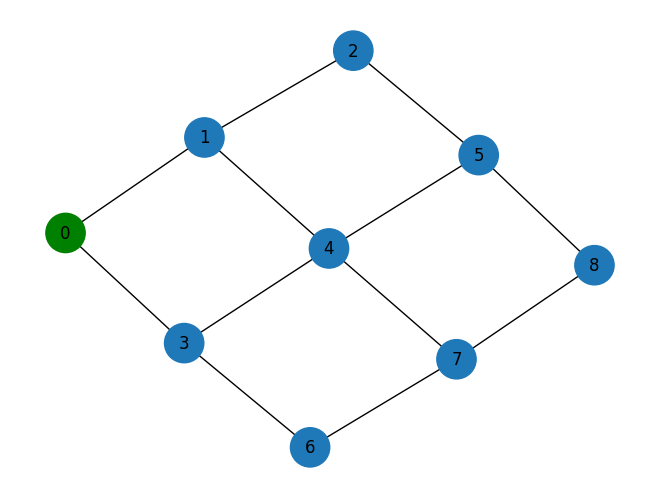

In [5]:
rede = Network()
rede.set_ready_topology('grade',8,3,3) 
rede.draw()
Logger.activate(Logger)

# Carrega o conjunto de dados Iris
- X → dados (características/features) 
- y → rótulos (classes/labels)

In [6]:
iris = load_iris()
X = iris.data 
y = iris.target

# Reduz para duas classes (binário)
- o QNN padrão trabalha com 0/1

- Por isso, o conjunto Iris foi reduzido para apenas 2 classes, ou seja, só foram usados os exemplos das flores das espécies setosa e versicolor, excluindo a terceira (virginica).
- Porém, as características (ou variáveis de entrada) — como comprimento e largura da sépala e da pétala — foram mantidas.
- Isso significa que só simplificamos as saídas (as classes), mas não mexemos nas entradas.

- Essa decisão foi feita para simplificar o código e permitir um foco mais direto no funcionamento do QML (Quantum Machine Learning) com redes neurais quânticas.
- Embora seja possível adaptar o QNN para problemas multiclasse, isso exigiria um código mais avançado 

In [7]:
X = X[y != 2]
y = y[y != 2]

# Divide os dados 
80% treino e 20% teste

- test_size -> define que 20% dos dados serão usados para teste (logo, 80% vão para treino)
- random_state -> os dados são embaralhados aleatoriamente antes de dividir em treino e teste.
- stratify -> mantém a mesma proporção de cada classe nos conjuntos de treino e teste (boa prática em classificações)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normaliza os dados
- Normalizar = colocar tudo na mesma escala (de 0 a 1).
- Isso ajuda o modelo a aprender melhor e evita que uma variável "grite" mais que as outras.
- ex: Se uma variável vai de 0 a 1000 e outra vai de 0 a 1, a maior domina o aprendizado

In [9]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define número de qubits
- Se o conjunto de dados tem 4 features (ex: comprimento da pétala, largura da pétala etc),
- então são necessários 4 qubits para representar e processar cada uma dessas features no circuito quântico.

In [10]:
num_qubits = X_train.shape[1]

# Feature map e ansatz
- Feature Map → insere as features no circuito quântico
- RealAmplitudes → um tipo específico de ansatz do Qiskit, onde ele monta um circuito que trabalha com rotações e entrelaçamento. Isso faz com que ele consiga representar padrões/pesos diferentes nas features. "onde tem peso para aprender"

- Quantos mais os números de reps crescer mais a chance de overfitting (treinar de uma forma errada)

In [11]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits, reps=1)

# Cria o circuito
- etapa que cria um circuito quântico vazio, transforma os dados clássicos (números normais) em um estado quântico e ) e depois coloca o ansatz para o modelo conseguir aprender os padrões/pesos das features.


In [12]:
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# EstimatorQNN
- Transforma o circuito (qc) em uma rede neural quântica treinável.

- E permite treinar ela usando PyTorch, igual uma rede neural clássica.

In [13]:
qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters) 
model = TorchConnector(qnn)

/tmp/ipykernel_9170/3022605767.py:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters)


# Otimização com PyTorch
- X_train_tensor e y_train_tensor → Convertem os dados de treino (X_train e y_train) de NumPy pra tensor do PyTorch, que é o formato que o modelo entende.

- optimizer = torch.optim.Adam(...) → Define o otimizador Adam, que ajusta os pesos do modelo pra minimizar o erro.

- lr=0.1 → Taxa de aprendizado (velocidade que ele ajusta os pesos com base nos erros, não pode ser muito alto e não muito baixo).

- loss_func = torch.nn.BCELoss() → Função de perda para problemas de classificação binária — mede o erro entre a saída do modelo (probabilidade) e o valor real (0 ou 1).

In [14]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_func = torch.nn.BCELoss()

# Treinamento
- model.train() → Coloca o modelo no modo treino
- optimizer.zero_grad() → Zera os gradientes dos cálculos anteriores pra não acumular.
- outputs = model(X_train_tensor) →  usa os dados de treino no modelo para fazer uma previsão/estimativa.
- loss → calcula o erro
- loss.backward() → Calcula os gradientes, ou seja, descobre pra onde e quanto cada peso deve mudar pra reduzir o erro.
- optimizer.step() → usa esses gradientes pra mudar os pesos do ansatz. Ele faz isso pra tentar diminuir o erro na próxima vez que roda

In [15]:
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = loss_func(torch.sigmoid(outputs.squeeze()), y_train_tensor)
    loss.backward()
    optimizer.step()

# Avaliação
- Primeiro ele, Faz previsão no conjunto de teste, sem atualizar o modelo.
- Transforma saída em probabilidade e decide se é classe 0 ou 1.
- Prepara os resultados para análise (cálculo das métricas).
# Métricas
- Acurácia: porcentagem de previsões corretas (tanto verdadeiros positivos quanto verdadeiros negativos).

- Precisão: proporção de previsões positivas que estavam corretas (foca em evitar falsos positivos).

- Recall: proporção de casos positivos corretamente identificados (foca em evitar falsos negativos).

In [16]:
with torch.no_grad():
    outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    y_pred = torch.sigmoid(outputs).round().numpy()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("MÉTRICAS:")
print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

MÉTRICAS:
Acurácia: 0.85
Precisão: 0.89
Recall: 0.80
F1: 0.84


## Conclusões e próximos passos

- O experimento de Blind Quantum Computing foi executado com sucesso.
- Próximos passos podem incluir: testar outros datasets, aprimorar o circuito quântico, ou analisar a segurança do protocolo.

In [17]:
circuit_depth = qc.depth()

print(f"Circuito do QNN tem profundidade: {circuit_depth}")

rede.application_layer.run_app(
    app_name="AC_BQC",
    alice_id=6,         
    bob_id=0,           
    num_qubits=num_qubits,
    scenario=1,        
    circuit_depth=circuit_depth
)

2025-06-30 12:08:46,255: Timeslot 0: Iniciando protocolo Andrew Childs entre Alice 6 e Bob 0.
2025-06-30 12:08:46,257: Limpando a memória do cliente (Alice) antes de iniciar o protocolo.
2025-06-30 12:08:46,257: Limpando a memória do servidor (Bob) antes de iniciar o protocolo.
2025-06-30 12:08:46,258: Cliente criou 4 qubits para a transmissão.
2025-06-30 12:08:46,259: Qubit 202 registrado no timeslot 0
2025-06-30 12:08:46,259: Qubit 981 registrado no timeslot 0
2025-06-30 12:08:46,260: Qubit 594 registrado no timeslot 0
2025-06-30 12:08:46,262: Qubit 435 registrado no timeslot 0
2025-06-30 12:08:46,262: Qubit 202 criado pelo Cliente - Estado: 0, Fase: 1
2025-06-30 12:08:46,265: Qubit 981 criado pelo Cliente - Estado: 0, Fase: 1
2025-06-30 12:08:46,265: Qubit 594 criado pelo Cliente - Estado: 0, Fase: 1
2025-06-30 12:08:46,266: Qubit 435 criado pelo Cliente - Estado: 0, Fase: 1
2025-06-30 12:08:46,266: Alice recebeu 4 qubits. Total: 4 qubits na memória.
2025-06-30 12:08:46,267: Instruç

Circuito do QNN tem profundidade: 2
Tempo de Operação: 2
